# Semantic chunking

Next, we are going to try using a semantic text splitter to chunk the text to blocks of around 512 tokens.

## 1. Run set-up

We will use semantic-text-splitter from PyPI and the bert base uncased tokenizer from HuggingFace.

In [1]:
# Change working directory to parent so we can import as we would from __main__.py
print(f'Working directory: ', end = '')
%cd ..

# Standard ports
import time

# PyPI imports
import h5py
import matplotlib.pyplot as plt
from semantic_text_splitter import TextSplitter
from tokenizers import Tokenizer

# Internal imports
import configuration as config

Working directory: /mnt/arkk/opensearch/semantic_search


In [2]:
input_file=f'{config.DATA_PATH}/wikipedia-sample/{config.BATCHED_TEXT}'

# Total line and record counts determined in data exploration notebook
line_count=13778448
record_count=6889224

tokenizer_name='bert-base-uncased'
max_tokens=512

tokenizer=Tokenizer.from_pretrained(tokenizer_name)
splitter=TextSplitter.from_huggingface_tokenizer(tokenizer, max_tokens)

## 2. Load data

Load up the first batch from the data extractor.

In [3]:
input_data=h5py.File(input_file, 'r')
batch=input_data['batches/1']

sample_text=' '.join(batch[0].decode('utf-8').split(' ')[:100])

print(f'First batch contains {len(batch)} texts\n')
print(f"Sample text:\n{sample_text}")

First batch contains 95 texts

Sample text:
Hercule Poirot (, ) is a fictional Belgian detective created by British writer Agatha Christie. Poirot is one of Christie's most famous and long-running characters, appearing in 33 novels, two plays (Black Coffee and Alibi), and 51 short stories published between 1920 and 1975.

Poirot has been portrayed on radio, in film and on television by various actors, including Austin Trevor, John Moffatt, Albert Finney, Peter Ustinov, Ian Holm, Tony Randall, Alfred Molina, Orson Welles, David Suchet, Kenneth Branagh, and John Malkovich.

Overview 

Influences 

Poirot's name was derived from two other fictional detectives of the time: Marie Belloc Lowndes' Hercule Popeau and


Ok, looks fine - we still have some character level garbage in there, but that will be cleaned up during the data transform task.

## 3. Semantic chunking test
Test split the first text from the first batch:

In [4]:
chunks=splitter.chunks(batch[0].decode('utf-8'))
print(f'Have {len(chunks)} chunks')

for i, chunk in enumerate(chunks[:5]):
    chunk_start=' '.join(chunk.split(' ')[:25])
    chunk_end=' '.join(chunk.split(' ')[-25:])
    print(f'\n{i}: {chunk_start} ... {chunk_end}')

Have 22 chunks

0: Hercule Poirot (, ) is a fictional Belgian detective created by British writer Agatha Christie. Poirot is one of Christie's most famous and long-running characters, ... Hanaud of the French Sûreté, who first appeared in the 1910 novel At the Villa Rose and predates the first Poirot novel by 10 years.

1: Christie's Poirot was clearly the result of her early development of the detective in her first book, written in 1916 and published in 1920. The ... taken to wearing a wig and a false moustache.as Hastings discovers in  However, in many of his screen incarnations, he is bald or balding.

2: Frequent mention is made of his patent leather shoes, damage to which is frequently a source of misery for him, but comical for the reader.E.g. ... the dark throughout the climax. This aspect of Poirot is less evident in the later novels, partly because there is rarely a narrator to mislead.

3: In Murder on the Links, still largely dependent on clues himself, Poirot mocks a rival

OK, pretty good. We didn't break up any sentences. Some chunks start with a pronoun, so they would be a little unclear to read in isolation. But this approach is obviously much better than taking chunks by word count.

It feels snappy too - let's time splitting a few batches and see what we are working with.

## 4. Semantic text splitting rate

In [5]:
%%time

# Number of batches to time splitting for
num_batches=100

# Holder to collect splitting rates
splitting_rates=[]

# Also, collect the number of chunks we get from each article
# so we can get an average at the end
chunks_per_article=[]

for i in range(num_batches):

    # Start the timer
    start_time=time.time()

    # Get the text batch
    batch=input_data[f'batches/{i + 1}']

    # Split the records from the batch
    for record in batch:
        chunks=splitter.chunks(record.decode('utf-8'))

        # Collect the chunk count
        chunks_per_article.append(len(chunks))

    # Stop the timer
    dT=time.time() - start_time

    # Collect the split rate
    splitting_rates.append(len(batch) / dT)

CPU times: user 2min 36s, sys: 82.1 ms, total: 2min 36s
Wall time: 2min 36s


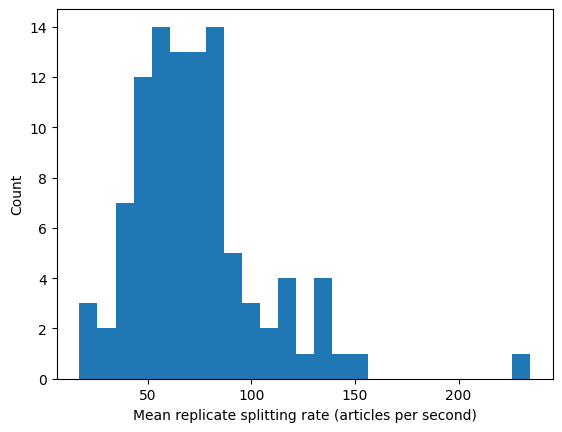


Estimated total splitting time: 26.2 hours
Mean splitting rate 72.9 records per second



In [8]:
plt.hist(splitting_rates, bins=25)
plt.xlabel(f'Mean replicate splitting rate (articles per second)')
plt.ylabel('Count')
plt.show()

mean_splitting_rate=sum(splitting_rates) / len(splitting_rates)
print(f'\nEstimated total splitting time: {((record_count / mean_splitting_rate) / (60**2)):.1f} hours')
print(f'Mean splitting rate {mean_splitting_rate:.1f} records per second\n')

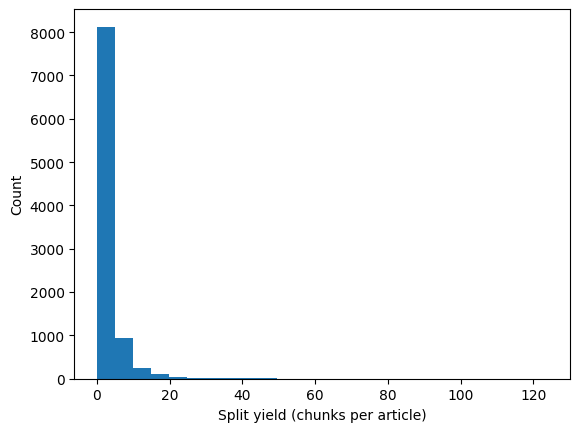


Estimated total chunks: 20648877
Mean chunks per article 3.0



In [9]:
plt.hist(chunks_per_article, bins=25)
plt.xlabel(f'Split yield (chunks per article)')
plt.ylabel('Count')
plt.show()

mean_chunks_per_article=sum(chunks_per_article) / len(chunks_per_article)
print(f'\nEstimated total chunks: {(record_count * mean_chunks_per_article):.0f}')
print(f'Mean chunks per article {mean_chunks_per_article:.1f}\n')

## 5. Results

Single threaded semantic splitting rate is about 60 records per second or approximately 30 hours to spit all of Wikipedia. Parallelizing that over 18 cores gives us a net splitting time of about an hour and 45 minutes. 

Combining the semantic splitting time with the net one-hour run time of the parallelized extractor/parser/cleaner functions, and we are looking at best case scenario, about 3 hours for the extraction job to complete. All-in-all, not terrible. We can live with overnight, especially considering that the first iteration of this pipeline would have taken over 8 days to run!